# Library imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Add, BatchNormalization, Activation
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display

# eda

In [2]:
data_path = '/kaggle/input/smoke-detection-dataset/smoke_detection_iot.csv'  
data = pd.read_csv(data_path)

print("Data Overview:")
print(data.info())  
print("\nMissing Values:")
print(data.isnull().sum())  

print("\nBasic Statistics:")
print(data.describe())  

Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62630 entries, 0 to 62629
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      62630 non-null  int64  
 1   UTC             62630 non-null  int64  
 2   Temperature[C]  62630 non-null  float64
 3   Humidity[%]     62630 non-null  float64
 4   TVOC[ppb]       62630 non-null  int64  
 5   eCO2[ppm]       62630 non-null  int64  
 6   Raw H2          62630 non-null  int64  
 7   Raw Ethanol     62630 non-null  int64  
 8   Pressure[hPa]   62630 non-null  float64
 9   PM1.0           62630 non-null  float64
 10  PM2.5           62630 non-null  float64
 11  NC0.5           62630 non-null  float64
 12  NC1.0           62630 non-null  float64
 13  NC2.5           62630 non-null  float64
 14  CNT             62630 non-null  int64  
 15  Fire Alarm      62630 non-null  int64  
dtypes: float64(8), int64(8)
memory usage: 7.6 MB
None

Missing Va

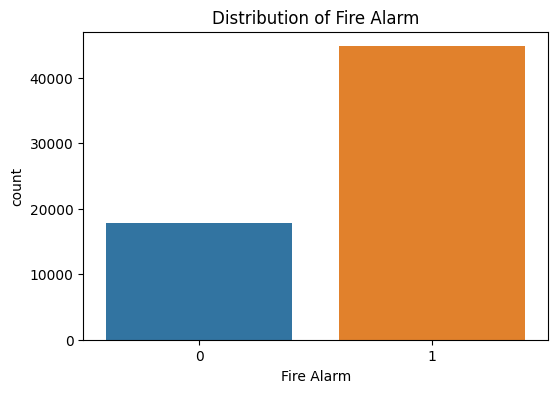

In [3]:

plt.figure(figsize=(6,4))
sns.countplot(x='Fire Alarm', data=data)
plt.title('Distribution of Fire Alarm')
plt.show()

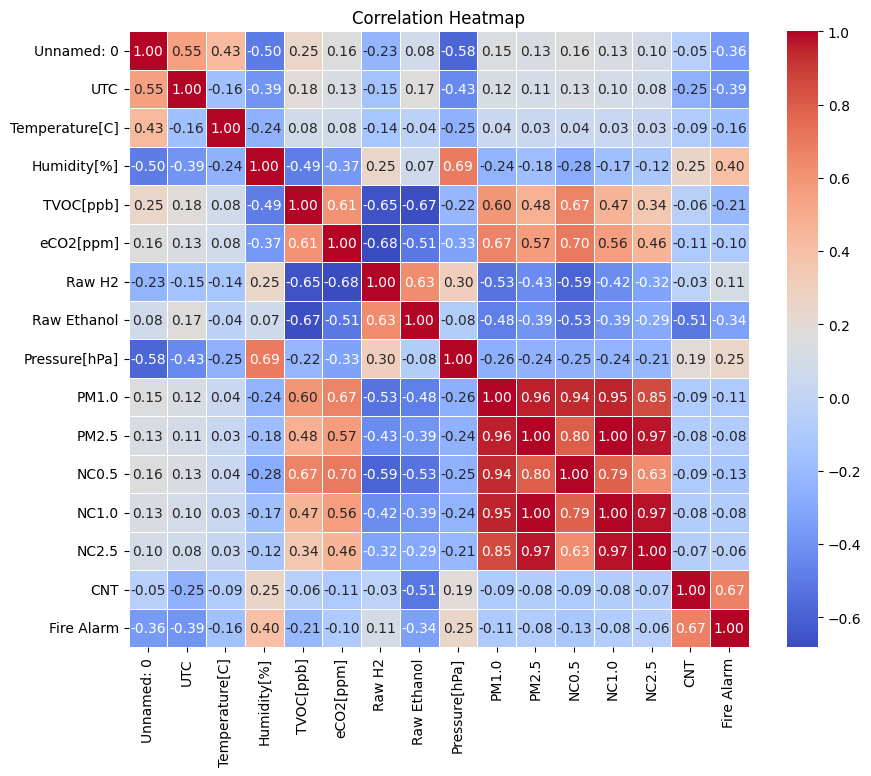

In [4]:

plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

<ipython-input-5-2055610202ff>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  corr.append(data_4[i])
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


Text(0.5, 1.0, 'Correlation coefficient between different features and Fire Alarm ')

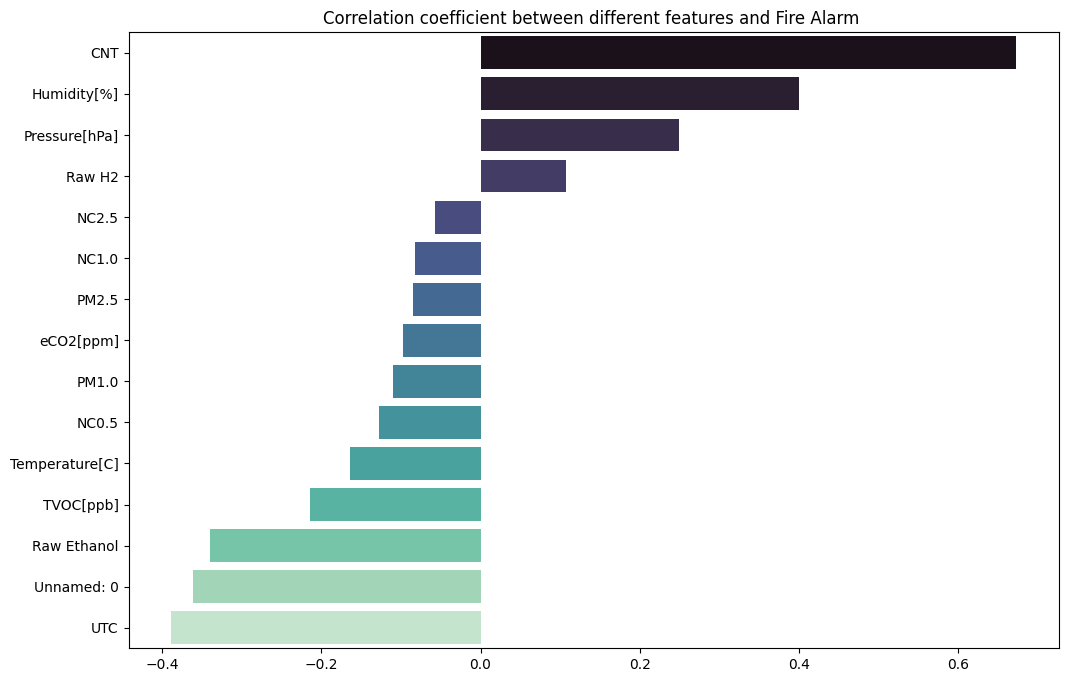

In [5]:
plt.figure(figsize=(12,8))
data_4 = data.corr()["Fire Alarm"].sort_values(ascending=False)
indices = data_4.index
labels = []
corr = []
for i in range(1, len(indices)):
    labels.append(indices[i])
    corr.append(data_4[i])
sns.barplot(x=corr, y=labels, palette='mako')
plt.title('Correlation coefficient between different features and Fire Alarm ')

In [6]:
# Data Cleaning: Drop columns that are unnecessary or have many missing values
data.drop(columns=['Unnamed: 0'], errors='ignore', inplace=True)
data.dropna(inplace=True)

X = data.drop(columns=['Fire Alarm'])
y = data['Fire Alarm']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)


In [7]:
def build_model(input_dim):
    inputs = Input(shape=(input_dim,))

    # First dense layer
    x = Dense(64, activation='relu')(inputs)
    x = BatchNormalization()(x)

    # Residual blocks (10 layers total)
    for _ in range(5):
        shortcut = x
        x = Dense(128, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dense(128, activation=None)(x)
        x = BatchNormalization()(x)

        if shortcut.shape[-1] != x.shape[-1]:
            shortcut = Dense(128, activation=None)(shortcut)

        x = Add()([shortcut, x])
        x = Activation('relu')(x)

    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    outputs = Dense(2, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    return model

input_dim=X_train.shape[1]
model = build_model(X_train.shape[1])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.9678 - loss: 0.0912 - val_accuracy: 0.9993 - val_loss: 0.0053
Epoch 2/10
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9953 - loss: 0.0156 - val_accuracy: 0.9989 - val_loss: 0.0064
Epoch 3/10
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9974 - loss: 0.0110 - val_accuracy: 0.9996 - val_loss: 0.0026
Epoch 4/10
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9978 - loss: 0.0081 - val_accuracy: 0.9991 - val_loss: 0.0038
Epoch 5/10
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9982 - loss: 0.0069 - val_accuracy: 0.9998 - val_loss: 0.0011
Epoch 6/10
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9977 - loss: 0.0078 - val_accuracy: 0.9994 - val_loss: 0.0020
Epoch 7/10
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9988 - loss: 0.0050 - val_accuracy: 0.9997 - val_loss: 0.0013
Epoch 8/10
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9980 - loss: 0.0082 -

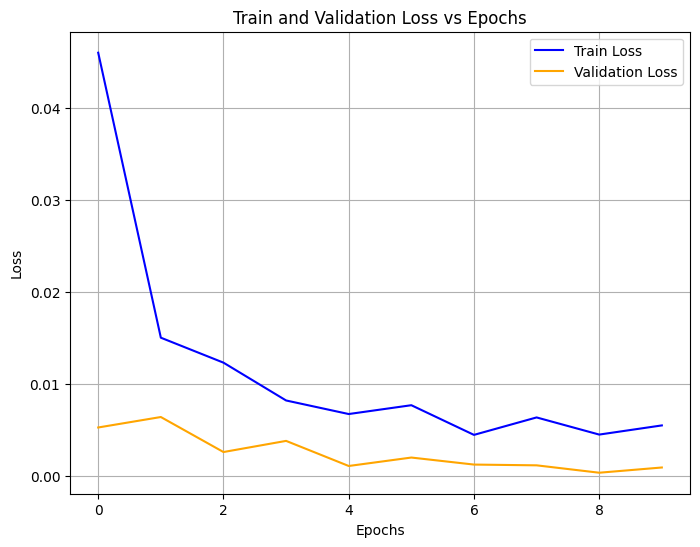

In [8]:
# Plotting Train and Validation Loss vs Epochs
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Train and Validation Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [9]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 99.97%


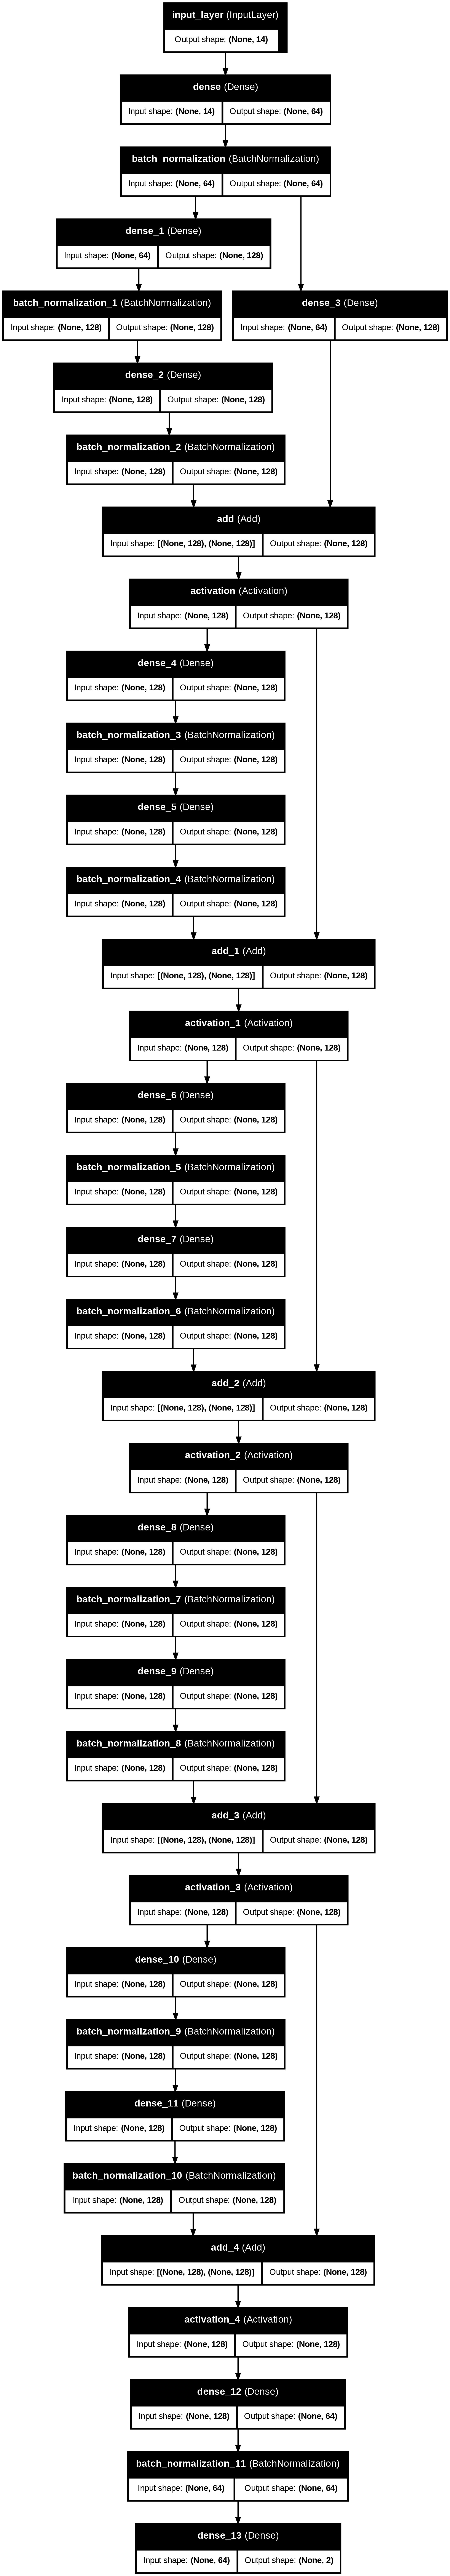

In [10]:
# Plot the model architecture and display it inline in Colab
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)
display(Image(filename='model_architecture.png'))

In [11]:
# Measure the original model size
model_size = model.count_params() * 4 / (1024 * 1024)  # Approximate size in MB (4 bytes per parameter)
print(f"Original Model Size: {model_size:.2f} MB")


converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_model_path = '/kaggle/working/smoke_detection_model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)
    print(f"Model has been converted and saved as {tflite_model_path}")

tflite_model_size = os.path.getsize(tflite_model_path) / (1024 * 1024)  # Size in MB
print(f"TFLite Model Size: {tflite_model_size:.2f} MB")

Original Model Size: 0.69 MB
Saved artifact at '/tmp/tmpm2ix9alw'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 14), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  132269806266224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132271427102048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132269796786240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132269796793984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132269796789232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132269796791520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132269796794864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132269796795744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132269796798912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132269796800672: TensorSpec(shape=(), dtype=tf.resource, name=No

In [12]:
# teacher_model=model
# # Define the student model (simpler version)
# student_model = tf.keras.models.Sequential([
#     Dense(32, activation='relu', input_shape=(input_dim,)),
#     BatchNormalization(),
#     Dense(64, activation='relu'),
#     BatchNormalization(),
#     Dense(2, activation='sigmoid')
# ])

# student_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Distillation loss function
# def distillation_loss(y_true, y_pred, y_teacher_pred, temperature=5):
#     teacher_probs = tf.nn.softmax(y_teacher_pred / temperature)
#     student_probs = tf.nn.softmax(y_pred / temperature)
#     return tf.keras.losses.KLDivergence()(teacher_probs, student_probs)

# # Train the student model using soft predictions from the teacher
# for epoch in range(5):
#     for x_batch, y_batch in zip(X_train, y_train):
#         x_batch = np.expand_dims(x_batch, axis=0) 
#         y_teacher_pred = teacher_model.predict(x_batch)  # Soft labels from teacher
#         student_model.train_on_batch(x_batch, y_teacher_pred)  # Train with distillation loss

# # Save the distilled model
# distilled_model_path = '/kaggle/working/smoke_detection_model_distilled.h5'
# student_model.save(distilled_model_path)

# print(f"Distilled Model Saved at: {distilled_model_path}")

In [13]:
# !pip install tensorflow-model-optimization
